# Go-Live Project Metrics Case Study
## Gompertz Model for number of tickets from Go-Live to achieve some metrics, evaluate, compare with other projects and have some tools to create KPIs

At first, and looking some go-live tickets (issues) generated during some different Go-Lives I thought that classic sigmoid function could fit my model.

However the real thing is that when you have release some new application in a production system, there is a gap between users starts to know/understand the functionallity of the new tool and detect issues or have questions about how it works, etc.. So at the start of the go-live *(if there are not really big issues, what is expected after a good UAT)* you don't expect to have several issues, so the growth at very initial point is slower than some days after, and of course, when the new application/tool/functionallity is coming more stable you should find that issues growth get slower another time.

This type of distribution is literally [Gompertz function](https://en.wikipedia.org/wiki/Gompertz_function), so my expectation is that I could fit this function to go-live ticketing and use its parameters as metrics and a quick knowledge of the Go-Live and Post-GoLive achievements.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sqlite3

sns.set()

In [2]:
#Gombertz fit and error discovery libraries
import sklearn.metrics as sklm
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [3]:
from plotnine import *

## Read Data

Our data is stored in SQLITE table, it comes from ticket managing tool is taking all tickets related to incidences, queries and small requests solved during Go-Live and post Go-Live support from a IT project.

<img src='http://www.fisoft.es/wp-content/uploads/2020/05/codigopixelado.png'>

In [4]:
con = sqlite3.connect("db.sqlite3")
cur = con.cursor()
sql = ['CLEARED FOR CONFIDENTIALITY']

raw_data = pd.read_sql(sql,con)
df = raw_data.copy()

In [5]:
raw_data.head() #Take a look of raw_data

,quantity,date
0,13,2020-01-27
1,4,2020-01-28
2,8,2020-01-29
3,7,2020-01-30
4,2,2020-01-31


## Data analysis and exploration

### Basic data statistics

In [6]:
# Change data type of 'date' column to pandas datatime index type.
df['date'] = df['date'].astype('datetime64[ns]')
df.index = df['date'] #Set date as index to create time dataframe.

In [7]:
# Usual aggrupations for temporal series discovery
df['Year'] = df.index.year
df['Month'] = df.index.month
#df['Day'] = df.index.weekday_name
df['Week'] = df.index.week
df['DayCount'] = np.arange(1,df['quantity'].shape[0]+1) #useful for functions

I'm going to show some exploratory data, only for take a look to the time series, but in next chapter I will show capital information about usual go-live distribution tickets and my hypotesis

In [8]:
df['quantity'].describe()

count    88.000000
mean      4.772727
std       3.143054
min       1.000000
25%       2.000000
50%       4.000000
75%       7.000000
max      14.000000
Name: quantity, dtype: float64

In [9]:
import statsmodels.api as sm
descomposicion = sm.tsa.seasonal_decompose(df['quantity'], model='additive', period=4)

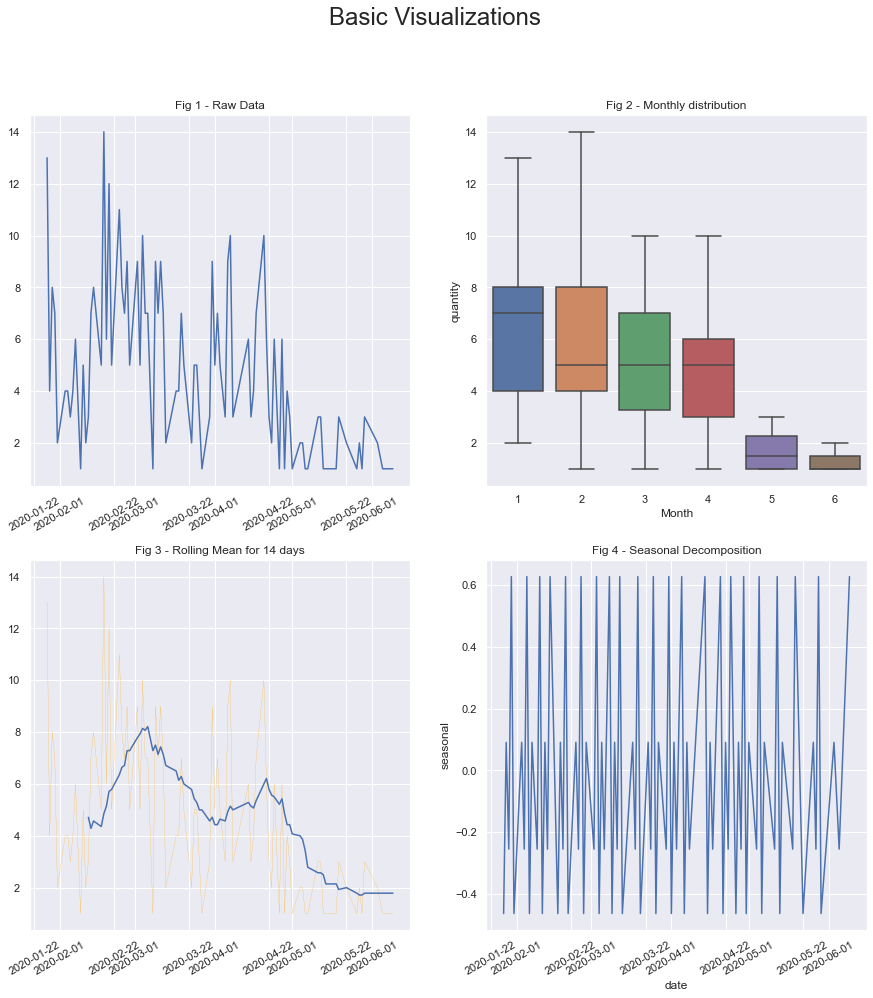

In [10]:
# Basic Graphical statistical Data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,15))
fig.suptitle('Basic Visualizations',size=24)
ax1.plot(df['date'], df['quantity'])
ax1.set_title('Fig 1 - Raw Data')
ax1.tick_params(axis='x',labelrotation=30)
ax2.set_title('Fig 2 - Monthly distribution')
sns.boxplot(x=df['Month'],y=df['quantity'],ax=ax2)
ax3.plot(df.index,df['quantity'],linewidth=0.2,c='orange')
ax3.plot(df.index,df['quantity'].rolling(14).mean())
ax3.tick_params(axis='x',labelrotation=30)
ax3.set_title('Fig 3 - Rolling Mean for 14 days')
ax4.set_title('Fig 4 - Seasonal Decomposition')
ax4.tick_params(axis='x',labelrotation=30)
ax4 = sns.lineplot(x=descomposicion.seasonal.index,y=descomposicion.seasonal);

##### Short comments:
*Fig 1* - Our Raw Data as it has been read from DDBB.

*Fig 2 - Fig 3* - Here you can see more or less the same, trend distribution of our number of tickets in different views.

*Fig 4* - Here we can check that possible seasonal data has been discarted, as the incidence (+/- 0,6 tickets/day) is not significant to our daily number of tickets during all the time series. (above you can see that the mean for all series is 4.9 tickets/day with std = 3)


### Looking for a Gomperz model behavior

We are looking for, and this was my first intuition, some 'draw' of our time series that could remember us to gomperz function, and when someone thinks about Gomperz function it comes more or less sigmoid function with relevant curves, but you have to 'imagine' also what could happen if you modify gomperz parameters, as the function could change in several ways. Here you have some possibilities (**Fig 5**):
<img src="http://www.fisoft.es/wp-content/uploads/2020/05/parameters.png" width="800">
*Wikipedia*

First of all, what means each parameter of the function?

$a$ is an asymptote, in our case, total number of tickets created since Go-Live

$b$ sets the displacement along x-axis, in our context could be useful to know when the major part of the users have started to test our new functionallity, etc...

$c$ sets the growth rate (y scaling), in terms of our context will give us the rate in how the tickets are created, it could be useful to know how much testing is done, if there are several users using the new functionallity, etc..

And now what can we get from our data

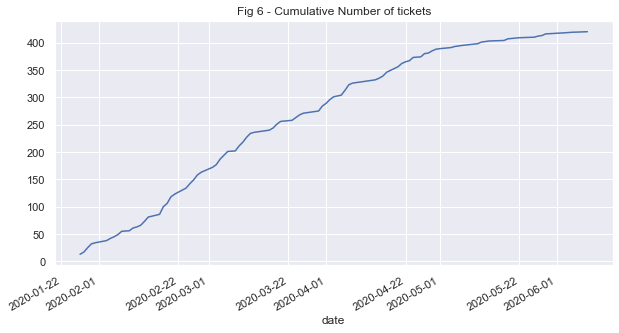

In [11]:
df['CumSum'] = df['quantity'].cumsum()
plt.figure(figsize=(10,5))
plt.title('Fig 6 - Cumulative Number of tickets')
df['CumSum'].plot();

Here we can find by looking the **Fig 6** that it seems that we have something to work with (**Fig 7**):
<img src="http://www.fisoft.es/wp-content/uploads/2020/05/buscandogompertz.png" width="600">

Also we can check the trend of our raw_data (I will filter it a bit with HP filter, but with rolling mean could be enough), as the cumulative data could be interpreted as the integral that goes from go-live start till last point, our raw data can then be interpreted as the derivative of that curve (**Fig 8**).

<img src="http://www.fisoft.es/wp-content/uploads/2020/05/acumuladoyderivada.png" width="360">

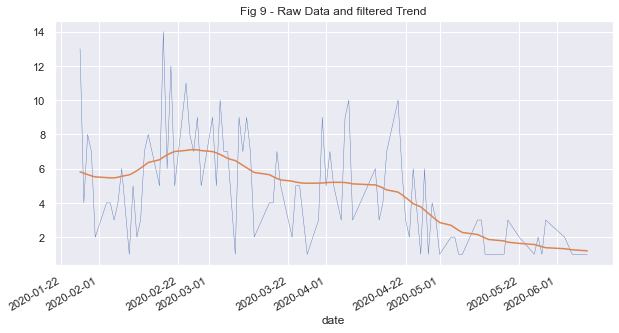

In [12]:
#Trend from filter Hodrick-Prescot)
from statsmodels.tsa.filters.hp_filter import hpfilter
hpcycle, df['Trend'] = hpfilter(df.quantity)
plt.figure(figsize=(10,5))
df['quantity'].plot(linewidth=0.4)
df['Trend'].plot()
plt.title('Fig 9 - Raw Data and filtered Trend');

As desired, the hypothetical derivative of a gomperz function has maximum (the famous maximum of pandemics) and then it has  to decrease asymptotically towards zero or a constant (approx). And I think that our case fits really good. So we are now confidents to start our modelization. After that the results will confirm or not all these previous analysis.

## Gompertz modelization of our data

We are going to try to fit our data to Sigmoid Gompertz Function:

### (1) $y(x) = a e^{-be^{-x/c}}$

and for future uses its derivate

### (2) $y'(x) = \frac{abe^{-be^{-x/c}-x/c}}{c}$


We are going to try to create our function with the parameters to fit and graph it to ensure that what we have is our Gompertz function ^^

In [26]:
def gompertz_model(x,a,b,c):
    return a*np.exp(-b*np.exp(-x/c))

def gompertz_derivate(x,a,b,c):
    return (a*b*np.exp((-b*np.exp(-x/c))-x/c))/c

tt= np.linspace(0,100,100)

x_data = tt
y_data = gompertz_model(tt, 400, 50, 12)
dataset = pd.DataFrame({'x_data': x_data, 'y_data': y_data})

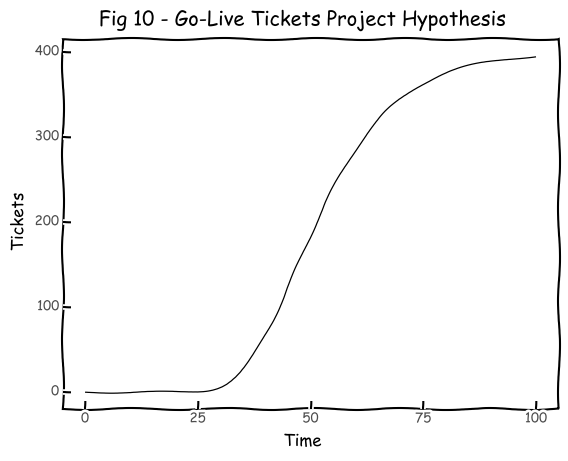

In [27]:
graf1 = (
    ggplot(dataset,aes(x='x_data',y='y_data')) +
    geom_line() +
    labs(x='Time',y='Tickets',title='Fig 10 - Go-Live Tickets Project Hypothesis') +
    theme_xkcd()
)
graf1.draw();

Well, it seems that we have some type of sigmoid function running and I am quite sure that it is our particular case for gompertz sigmoid function :)

Ok, it's the moment, we will use non-linear least squares regression to fit our function to our given data array (cumulative tickets by day).

In [14]:
x = df['DayCount'].values  
y = df['CumSum'].values    

y0 = y[0]
yf = y[-1]

print("Some data for our adjustment:")
print("--------------------------------")
print("Initial number of tickets: ", y0)
print("Current number of tickets: ", yf)
print("Number of days:            ", x[-1])

Some data for our adjustment:
--------------------------------
Initial number of tickets:  13
Current number of tickets:  412
Number of days:             83


In [15]:
#Gompertz Modelization'
fit_i = curve_fit(gompertz_model,x,y)
ai,bi,ci = fit_i[0]
sigma_ai, sigma_bi, sigma_ci = np.sqrt(np.diag(fit_i[1]))

## Results Analysis

So, at the end of modelization we have our Gomperz parametrized and its derivate. With parameters:

In [16]:
print('Final parameters for our modeled function:')
print('------------------------------------------')
print('a = {:.3f}'.format(ai),'+/- {:.3f}'.format(sigma_ai))
print('b = {:.3f}'.format(bi),'+/- {:.3f}'.format(sigma_bi))
print('c = {:.3f}'.format(ci),'+/- {:.3f}'.format(sigma_ci))

Final parameters for our modeled function:
------------------------------------------
a = 457.017 +/- 4.470
b = 3.184 +/- 0.053
c = 24.032 +/- 0.493


### Visualization comparision

#### Gompertz Function

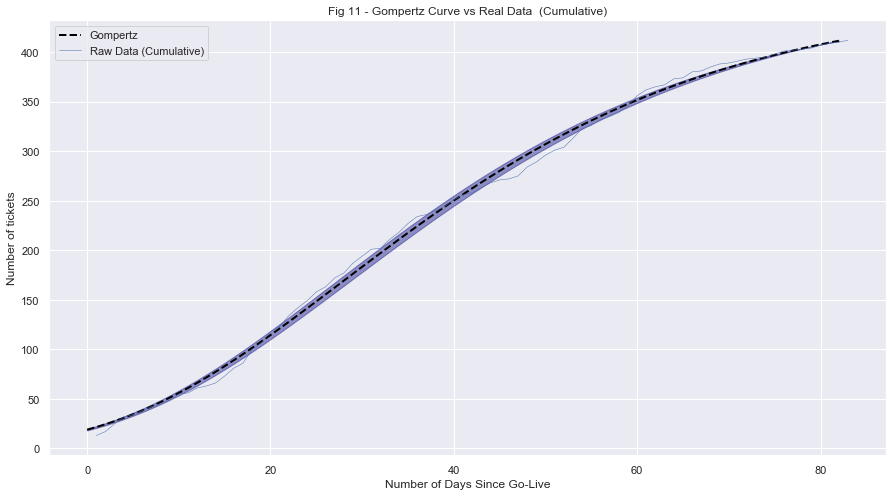

In [17]:
# Real data vs Modeled Data
tt= np.linspace(0,82,82)
plt.figure(figsize=(15,8))
plt.title('Fig 11 - Gompertz Curve vs Real Data  (Cumulative)')
plt.plot(tt, gompertz_model(tt, ai, bi, ci), c='black', linestyle='--', label='Gompertz', linewidth=2)
upper_lim = gompertz_model(tt, ai+sigma_ai, bi+sigma_bi, ci+sigma_ci)
lower_lim = gompertz_model(tt, ai-sigma_ai, bi-sigma_bi, ci-sigma_ci)
plt.fill_between(tt, upper_lim, lower_lim, color='navy', alpha=0.4)
plt.plot(df['DayCount'],df['CumSum'],label='Raw Data (Cumulative)', linewidth=0.5)
plt.ylabel('Number of tickets')
plt.xlabel('Number of Days Since Go-Live')
plt.legend();

#### Derivate Goompertz Function

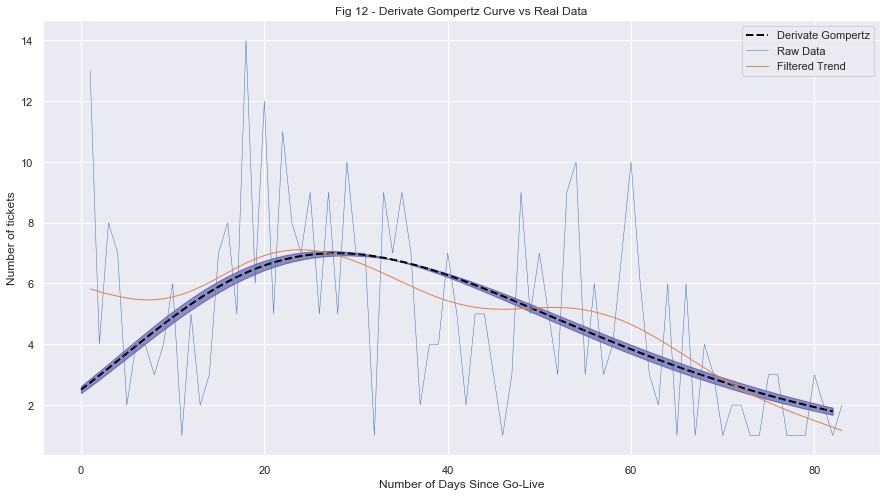

In [18]:
# Real data vs Modeled Data
tt= np.linspace(0,82,82)
plt.figure(figsize=(15,8))
plt.title('Fig 12 - Derivate Gompertz Curve vs Real Data')
plt.plot(tt, gompertz_derivate(tt, ai, bi, ci), c='black', linestyle='--', label='Derivate Gompertz', linewidth=2)
upper_lim = gompertz_derivate(tt, ai+sigma_ai, bi+sigma_bi, ci+sigma_ci)
lower_lim = gompertz_derivate(tt, ai-sigma_ai, bi-sigma_bi, ci-sigma_ci)
plt.fill_between(tt, upper_lim, lower_lim, color='navy', alpha=0.4)
plt.plot(df['DayCount'],df['quantity'],label='Raw Data', linewidth=0.5)
plt.plot(df['DayCount'],df['Trend'],label='Filtered Trend', linewidth=1)
plt.ylabel('Number of tickets')
plt.xlabel('Number of Days Since Go-Live')
plt.legend();

I think that it's quite beautiful the way as the model fits to the real data. We are going to evaluate it with objective data, but in terms of visualization I think that Gompertz could be good way to evaluate how a project is released in production system and how confidence, stable and well tested it is, by comparing Gompertz function parameters, with objectives, or other projects you have analyzed. 

### Error analysis

*Note: We will need to found roots for $y''$ so, we are going to develop it a bit*

We have our derivate:

(2) $y'(x) = \frac{abe^{-be^{-x/c}-x/c}}{c}$

And we are going to derivate another time:
(3) $y''(x) = - \frac{ab(e^{x/c}-b)e^{-be^{-x/c}-2x/c}}{c^2}$

In [19]:
def gompertz_derivate2(x,a,b,c):
    numerator = a*b*(np.exp(x/c)-b)*np.exp((-b*np.exp(-x/c))-2*x/c)
    return -(numerator/(c*c))

In [20]:
x = df['DayCount'].values
y = df['CumSum'].values

y_pred = gompertz_model(x,ai,bi,ci)

MSLE=sklm.mean_squared_log_error(y,y_pred)
MSE =sklm.mean_squared_error(y,y_pred)
print("Mean squared log error (MSLE): ", '{:.3f}'.format(MSLE))
print("Root Mean squared error (RMSE): ", '{:.3f}'.format(np.sqrt(MSE)))
R2 = sklm.r2_score(y,y_pred)
print("R2 score: ", '{:.3f}'.format(R2))

raw_sol = fsolve(lambda x : gompertz_derivate2(x,ai,bi,ci), 40)
#40 is an estimation by looking graph 
#(20-40 any number is fine, as our maximum is there and we need for solve non-linear function)
#Check the zero.
check_value = gompertz_derivate2(raw_sol[0],ai,bi,ci)
print('How zero is our solution?',check_value)
sol = int(round(raw_sol[0]))
print('Days to the Maximum since Go-Live: ', sol)
datesol = datetime.datetime.strftime(df.index[0] + datetime.timedelta(days=sol), ' %d, %b %Y' )
print('Day of flattening of Post Go-Live Support: ',datesol)

Mean squared log error (MSLE):  0.006
Root Mean squared error (RMSE):  6.734
R2 score:  0.997
How zero is our solution? -0.0
Days to the Maximum since Go-Live:  28
Day of flattening of Post Go-Live Support:   24, Feb 2020


**MSLE**: Mean squared logarithmic error (MSLE) can be interpreted as a measure of the ratio between the true and predicted values, will treat small differences between small true and predicted values approximately the same as big differences between large true and predicted values. Finally, MSLE also penalizes underestimates more than overestimates, introducing an asymmetry in the error curve.

In our case is fine, but it's not really significant as we have low values...

**RMSE**: RMSE is the average squared difference between the estimated values and its root (the good thing is that it comes to us in the same units so it's in acumulated tickets/day and it's really good.  $RMSE = \sqrt{\frac{1}{n}\sum^n_{i=1}(Y_i - Y_i)²}$

**$R^2$**: The great one, $R^2$ near to 1 means that we are really close to perfect model fit of our raw data behavior, and we have achieve $R^2=$ close to 1, it's not a surprise as we have seen in previous visualization that something has to be really wrong to don't have number near to 1.

Finally some additional data, we can calculate the maximum of our derivative model to know where is the *'critical'* point of our go-live, that in this case is after 27 days, and could be good Metric for our KPI's, and also if we are using data to make some prediction it could let us know when arrived to the maximum how much days we will have over **Business as Usual** tickets for this project.

## Another Go-Live to compare (Quick Review)

<img src='http://www.fisoft.es/wp-content/uploads/2020/05/codigopixelado.png'>

In [21]:
con = sqlite3.connect("db.sqlite3")
cur = con.cursor()
sql = ['CLEARED FOR CONFIDENTIALITY']

raw_data = pd.read_sql(sql,con)
df = raw_data.copy()
df.head()

,quantity,date
0,1,2019-10-03
1,3,2019-10-08
2,1,2019-10-09
3,1,2019-10-10
4,5,2019-10-11


### Exploring the data
Here we are going to go 'quick' and check what we want, that is the cumulative tickets vs the tickets per day in a trend way to avoid 'noise'.

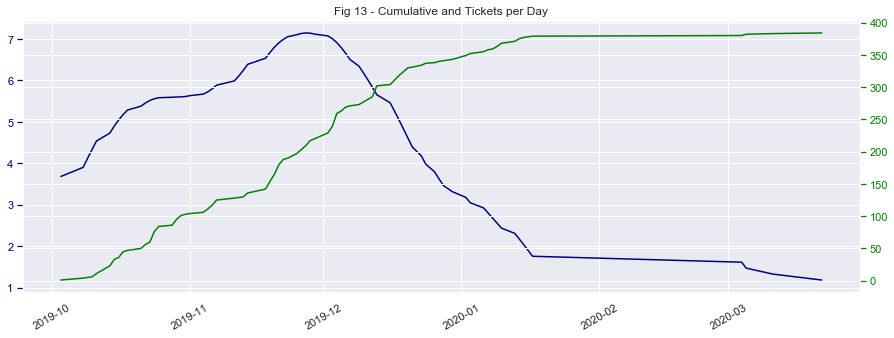

In [22]:
# Change data type of 'date' column to pandas datatime index type.
df['date'] = df['date'].astype('datetime64[ns]')
df.index = df['date'] #Set date as index to create time dataframe.

df['DayCount'] = np.arange(1,df['quantity'].shape[0]+1)

#Trend from filter Hodrick-Prescot)
from statsmodels.tsa.filters.hp_filter import hpfilter
hpcycle, df['Trend'] = hpfilter(df.quantity)
df['CumSum'] = df.quantity.cumsum()

#graficamos tendencia y cumsum
fig, ax = plt.subplots(figsize=(15,5))
ax2 = ax.twinx()
ax.plot(df.index,df['Trend'],color='navy')
ax2.plot(df.index,df['CumSum'],color='green')
ax.tick_params(axis="y", colors="navy")
ax2.tick_params(axis="y", colors="green")
ax.tick_params(axis='x',labelrotation=30)
plt.title('Fig 13 - Cumulative and Tickets per Day')
plt.show();

Well it's clear that here we have another exptected behavior that will let us to use our sigmoid particular function. So let's go to modelize it.

### Modeling

In [23]:
x = df['DayCount'].values  
y = df['CumSum'].values    

y0 = y[0]
yf = y[-1]

print("Some data for our adjustment:")
print("--------------------------------")
print("Initial number of tickets: ", y0)
print("Current number of tickets: ", yf)
print("Number of days:            ", x[-1])

#Gompertz Modelization'
fit_i = curve_fit(gompertz_model,x,y)
ai,bi,ci = fit_i[0]
sigma_ai, sigma_bi, sigma_ci = np.sqrt(np.diag(fit_i[1]))

Some data for our adjustment:
--------------------------------
Initial number of tickets:  1
Current number of tickets:  384
Number of days:             78


So, at the end of modelization we have our Gomperz parametrized and its derivate. With parameters:

In [24]:
print('Final parameters for our modeled function:')
print('------------------------------------------')
print('a = {:.3f}'.format(ai),'+/- {:.3f}'.format(sigma_ai))
print('b = {:.3f}'.format(bi),'+/- {:.3f}'.format(sigma_bi))
print('c = {:.3f}'.format(ci),'+/- {:.3f}'.format(sigma_ci))

Final parameters for our modeled function:
------------------------------------------
a = 437.599 +/- 5.980
b = 3.637 +/- 0.086
c = 22.591 +/- 0.607


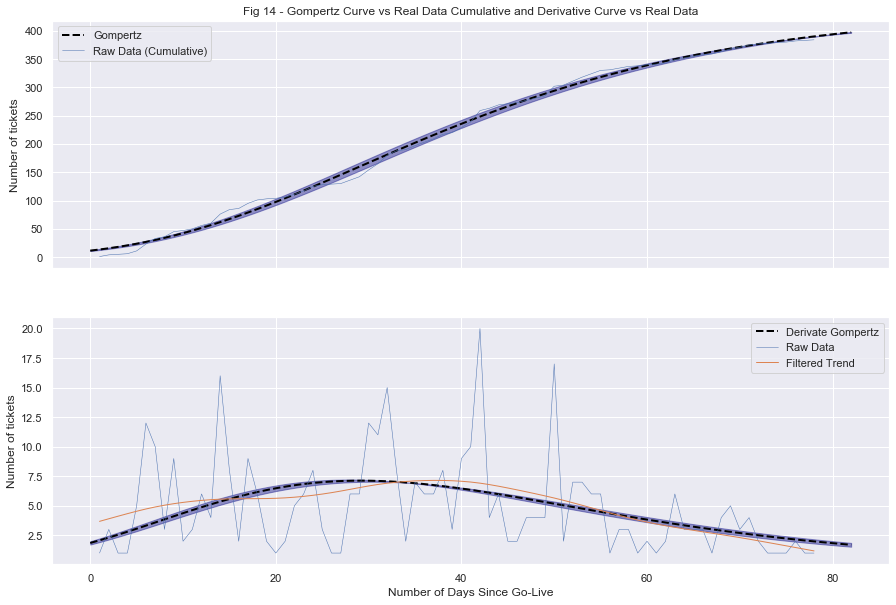

In [25]:
plt.figure(1, figsize=(15,10))



# Real data vs Modeled Data
ax1 = plt.subplot(211)
plt.title('Fig 14 - Gompertz Curve vs Real Data Cumulative and Derivative Curve vs Real Data')
tt= np.linspace(0,82,82)
plt.plot(tt, gompertz_model(tt, ai, bi, ci), c='black', linestyle='--', label='Gompertz', linewidth=2)
upper_lim = gompertz_model(tt, ai+sigma_ai, bi+sigma_bi, ci+sigma_ci)
lower_lim = gompertz_model(tt, ai-sigma_ai, bi-sigma_bi, ci-sigma_ci)
plt.fill_between(tt, upper_lim, lower_lim, color='navy', alpha=0.4)
plt.plot(df['DayCount'],df['CumSum'],label='Raw Data (Cumulative)', linewidth=0.5)
plt.setp(ax1, xticklabels=[])
plt.ylabel('Number of tickets')
plt.legend();



# Real data vs Modeled Data
plt.subplot(212)
tt= np.linspace(0,82,82)
plt.plot(tt, gompertz_derivate(tt, ai, bi, ci), c='black', linestyle='--', label='Derivate Gompertz', linewidth=2)
upper_lim = gompertz_derivate(tt, ai+sigma_ai, bi+sigma_bi, ci+sigma_ci)
lower_lim = gompertz_derivate(tt, ai-sigma_ai, bi-sigma_bi, ci-sigma_ci)
plt.fill_between(tt, upper_lim, lower_lim, color='navy', alpha=0.4)
plt.plot(df['DayCount'],df['quantity'],label='Raw Data', linewidth=0.5)
plt.plot(df['DayCount'],df['Trend'],label='Filtered Trend', linewidth=1)
plt.ylabel('Number of tickets')
plt.xlabel('Number of Days Since Go-Live')
plt.legend();

In [26]:
x = df['DayCount'].values
y = df['CumSum'].values

y_pred = gompertz_model(x,ai,bi,ci)

MSLE=sklm.mean_squared_log_error(y,y_pred)
MSE =sklm.mean_squared_error(y,y_pred)
print("Mean squared log error (MSLE): ", '{:.3f}'.format(MSLE))
print("Root Mean squared error (RMSE): ", '{:.3f}'.format(np.sqrt(MSE)))
R2 = sklm.r2_score(y,y_pred)
print("R2 score: ", '{:.3f}'.format(R2))

raw_sol = fsolve(lambda x : gompertz_derivate2(x,ai,bi,ci), 40)
#40 is an estimation by looking graph 
#(20-40 any number is fine, as our maximum is there and we need for solve non-linear function)
#Check the zero.
check_value = gompertz_derivate2(raw_sol[0],ai,bi,ci)
print('How zero is our solution?',check_value)
sol = int(round(raw_sol[0]))
print('Days to the Maximum since Go-Live: ', sol)
datesol = datetime.datetime.strftime(df.index[0] + datetime.timedelta(days=sol), ' %d, %b %Y' )
print('Day of flattening of Post Go-Live Support: ',datesol)

Mean squared log error (MSLE):  0.114
Root Mean squared error (RMSE):  7.926
R2 score:  0.996
How zero is our solution? -0.0
Days to the Maximum since Go-Live:  29
Day of flattening of Post Go-Live Support:   01, Nov 2019


## Conclusions

**I think that we are quite sure that our hypothesis that Gompertz Function and its study will let us to describe objective way Go-Live process in an IT department has been demonstrated**. With 3 different numbers ($a,b,c$) we are able to know how Go-Live process has been executed.

Each IT Department will be the responsible then, that using this 3 parameters and the meaning of all of them to decide wich values are 'correct' or intervals of confidence that brings an objective way to stablish some KPI for the Go-Live projects. It could be necessary a bit of work as you need to compare through other projects of your company to be able to know which is the normal situation of a Go-Live project.

For example, using only my 2 samples, it seems that in a Global Go-Live of studied company that impact all the users of the company, go-live and post-golive support should have 1 month of really hard work till the maximum of ticket creation, and then 2 month aprox of stabilization of the new functionallity. If this is usual behavior of the global projects, it will let us to standarize some type of start point to begin to improving this numbers for example for future projects, or to scalate support/project teams, etc...

I will try to make some approach using forecasting in next chapter to 'imagine' that we are in a go-live process in the middle of the curve and try to predict some future data. I will use the same data as above, but 'cutting' the data in a short time (we will try to see different casuistics, before the maximum, after, etc..)